# Cálculo de Coste Operativo y Congestión, Apoyo de Waze
## Centro Avanzado de Gestión del Tráfico (ATMS)

## Introducción
El coste operativo de congestión es un indicador clave para evaluar la eficiencia del tráfico en una ciudad. Utilizando datos de Waze, podemos calcular este coste y analizar su impacto en la movilidad urbana.

## Metodología
1. **Recopilación de Datos**: 
- Utilizar la API de Waze para obtener datos de tráfico en tiempo real, incluyendo tiempos de viaje, velocidad media y congestión en diferentes rutas.
- Utilizar datos históricos de base de datos de waze para el mismo propósito.

Estructura de datos de congestión (jams):

| Columna        | Descripción                                     |
|----------------|-------------------------------------------------|
| pk             | Identificador único de la congestión            |
| id             | Identificador alternativo                       |
| time_stamp     | Fecha y hora de detección                       |
| geom           | Geometría lineal que representa la congestión   |
| street         | Nombre de la calle afectada                     |
| city           | Ciudad donde ocurre la congestión               |
| country        | Código de país                                  |
| jam_speed      | Velocidad promedio en la congestión (km/h)      |
| jam_speed_mph  | Velocidad promedio en millas por hora           |
| jam_length     | Longitud de la congestión en metros             |
| jam_length_ft  | Longitud de la congestión en pies               |
| delay_seconds  | Retraso estimado en segundos                    |
| delay_minutes  | Retraso estimado en minutos                     |
| road_type      | Tipo de vía (codificado numéricamente)          |
| start_node     | Nodo de inicio del segmento congestionado       |
| end_node       | Nodo final del segmento congestionado           |
| jam_level      | Nivel de congestión (1-5, donde 5 es el peor)   |
| uuid           | Identificador único universal                   |


2. **Fuentes externas y Referencias**: 
- TablaResumen: Tabla de coste operativo y coste por emisiones guaraníes/kilómetro (vehículo)
- longitud_vehiculo: 7.5 metros (longitud promedio de un vehículo incluyendo bocacalles, etc.)
- Carriles: 2
- Dólar: 7.698 Gs.

3. **Análisis de Datos**: Procesar los datos para calcular el coste operativo y el coste de emisiones asociado.
- Consulta Base de Datos PostgreSQL.
- Consulta API Waze en vivo (no implementado).

**Datos base**
- hora_dia: Hora del día correspondiente al registro.
- velocidad_prom_kmh: Calcular velocidad media (km/h) por hora del día.
- longitud_tramo_km_prom: Longitud promedio de los tramos (km).
- vehiculos_tramo_prom: Promedio de vehículos por tramo.
- num_registros_waze_hora: Número de registros de Waze por hora.

**Emisiones**
- emisiones_vehiculo_promedio_gs: Emisiones promedio por vehículo (guaraníes/kilómetro).
- emisiones_tramo_promedio_gs: Emisiones promedio por tramo (guaraníes/kilómetro).
- emisiones_tramo_global_gs: Emisiones totales por todos los tramos (guaraníes/kilómetro).

**Coste Operativo**
- coste_operativo_vehiculo_promedio_gs: Coste operativo promedio por vehículo (guaraníes/kilómetro).
- coste_operativo_tramo_promedio_gs: Coste operativo promedio por tramo (guaraníes/kilómetro).
- coste_operativo_tramo_global_gs: Coste operativo total por todos los tramos (guaraníes/kilómetro).

4. **Cálculos**
**Cálculo de Datos Base**
Para calcular los datos base, se utilizarán las siguientes fórmulas:
hora_dia = números del 0 al 23 (representando cada hora del día)
velocidad_prom_kmh = promedio velocidad de los registros de Waze por hora del día
longitud_tramo_km_prom = promedio de la longitud de los tramos (en km) de los registros de Waze por hora del día
vehiculos_tramo_prom = carriles(2)*((longitud_tramo_km_prom * 1000) / longitud_vehiculo)  # Promedio de vehículos por tramo
num_registros_waze_hora = count(jams[timestamp]==hora_dia)  # Número de registros de Waze por hora

**Cálculo Coste Operativo**
Para calcular el coste operativo de congestión, se utilizarán las siguientes fórmulas:
- **coste_operativo_vehiculo_promedio**: Tendencia(TablaResumen[coste_gs_automovil],TablaResumen[velocidad_invertida],1/velocidad_prom_kmh)
- **coste_operativo_tramo_promedio_gs**: coste_operativo_vehiculo_promedio * vehiculos_tramo_prom * longitud_tramo_km_prom
- **coste_operativo_tramo_global_gs**: coste_operativo_tramo_promedio * num_registros_waze_hora

**Cálculo Coste de Emisiones**
Para calcular el coste de emisiones, se utilizarán las siguientes fórmulas:
- **emisiones_vehículo_promedio_gs**: Tendencia(TablaResumen[total_emisiones],TablaResumen[velocidad_invertida],1/velocidad_prom_kmh)
- **emisiones_tramo_promedio_gs**: emisiones_vehículo_promedio_gs * vehiculos_tramo_prom * longitud_tramo_km_prom
- **emisiones_tramo_global_gs**: emisiones_tramo_promedio_gs * num_registros_waze_hora

## Paso 1: Conexión y extracción de datos de congestión (jams)
En esta celda se realiza la conexión a la base de datos PostgreSQL y se extraen los datos relevantes de la tabla `w4c.detected_jams` para los últimos 2 días. Solo se seleccionan las columnas necesarias para los cálculos posteriores: pk, time_stamp, jam_speed, jam_length, street, city, jam_level.

In [1]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from datetime import datetime, timedelta
import os
from dotenv import load_dotenv

# Cargar variables de entorno desde .env
load_dotenv(".env")

DB_HOST = os.getenv('DB_HOST')
DB_PORT = os.getenv('DB_PORT')
DB_USER = os.getenv('DB_USER')
DB_PASS = os.getenv('DB_PASS')
DB_NAME = os.getenv('DB_NAME')
DB_SCHEMA = os.getenv('DB_SCHEMA')

# Crear string de conexión
conn_str = f"postgresql+psycopg2://{DB_USER}:{DB_PASS}@{DB_HOST}:{DB_PORT}/{DB_NAME}"
engine = create_engine(conn_str)


### Consulta de cobertura de datos por día y resumen mensual (2022-2024)
Esta sección permite visualizar la cobertura de datos históricos de congestión, mostrando la cantidad de registros por día y un resumen mensual por año. Es útil para identificar periodos con datos faltantes o baja cobertura antes de realizar análisis más detallados.

In [2]:
# Consulta SQL: cantidad de registros por día
query_cobertura_dia = f'''
SELECT DATE(time_stamp) AS fecha, COUNT(*) AS registros
FROM {DB_SCHEMA}.detected_jams
WHERE time_stamp >= '2022-01-01' AND time_stamp < '2025-01-01'
GROUP BY fecha
ORDER BY fecha
'''

try:
    df_cobertura_dia = pd.read_sql_query(query_cobertura_dia, engine)
    print("Cobertura diaria (primeras filas):")
    display(df_cobertura_dia.head())
except Exception as e:
    print("Error en la consulta de cobertura diaria:", e)

Cobertura diaria (primeras filas):


,fecha,registros
0,2022-01-01,869
1,2022-01-02,709
2,2022-01-03,2871
3,2022-01-04,3396
4,2022-01-05,4110



Resumen mensual de registros de congestión por año (2022-2024):


,Enero,Febrero,Marzo,Abril,Mayo,Junio,Julio,Agosto,Septiembre,Octubre,Noviembre,Diciembre
anio,,,,,,,,,,,,
2022,76676,119219,168346,145667,154074,151908,133130,146943,152455,156681,160430,152295
2023,101991,3953,0,20,175679,172146,146287,167776,13374,0,0,0
2024,0,0,0,118065,186310,188564,180956,185693,184683,213409,198197,184001


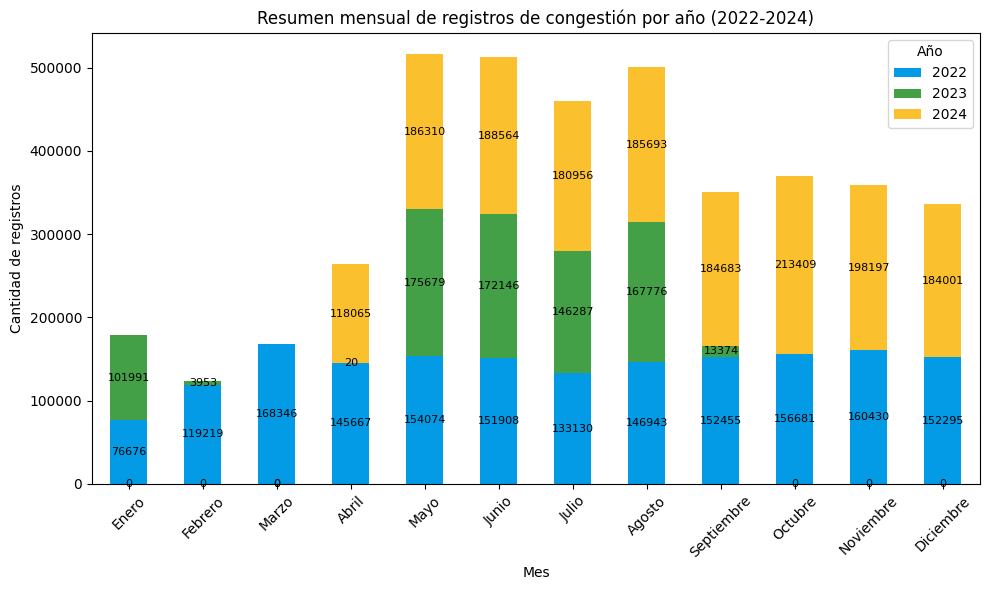

In [3]:
# Resumen anual y mensual: cantidad de registros por mes y año (2022-2025) con etiquetas en las barras
if 'df_cobertura_dia' in locals():
    df_cobertura_dia['fecha'] = pd.to_datetime(df_cobertura_dia['fecha'])
    df_cobertura_dia['anio'] = df_cobertura_dia['fecha'].dt.year
    df_cobertura_dia['mes'] = df_cobertura_dia['fecha'].dt.month
    resumen_anual_mensual = df_cobertura_dia.groupby(['anio', 'mes'])['registros'].sum().unstack(fill_value=0)
    resumen_anual_mensual.columns = [
        'Enero', 'Febrero', 'Marzo', 'Abril', 'Mayo', 'Junio',
        'Julio', 'Agosto', 'Septiembre', 'Octubre', 'Noviembre', 'Diciembre'
    ][:resumen_anual_mensual.shape[1]]
    print("\nResumen mensual de registros de congestión por año (2022-2024):")
    display(resumen_anual_mensual)
    # Visualización: gráfico de barras apiladas por año con etiquetas
    ax = resumen_anual_mensual.T.plot(kind='bar', stacked=True, figsize=(10,6),
                                      title='Resumen mensual de registros de congestión por año (2022-2024)',
                                      color=["#039be5", "#43a047", "#fbc02d"][:resumen_anual_mensual.shape[0]])
    # Añadir etiquetas pequeñas en cada barra
    for contenedor in ax.containers:
        ax.bar_label(contenedor, label_type='center', fontsize=8, color='black', fmt='%d')
    ax.set_ylabel('Cantidad de registros')
    ax.set_xlabel('Mes')
    ax.legend(title='Año')
    ax.set_xticklabels(resumen_anual_mensual.columns, rotation=45)
    import matplotlib.pyplot as plt
    plt.tight_layout()
    plt.show()
else:
    print("No se pudo calcular el resumen anual/mensual por falta de datos diarios.")

In [4]:
# Calcular fechas para el año 2022
fecha_ini = datetime(2022, 1, 1)
fecha_fin = datetime(2022, 12, 31)

# Consulta SQL segura para el año 2022
query = f'''
SELECT pk, time_stamp, jam_speed, jam_length, street, city, jam_level
FROM {DB_SCHEMA}.detected_jams
WHERE time_stamp >= '{fecha_ini.strftime('%Y-%m-%d %H:%M:%S')}' AND time_stamp < '{fecha_fin.strftime('%Y-%m-%d %H:%M:%S')}'
'''

# Leer datos a DataFrame
try:
    df_jams = pd.read_sql_query(query, engine)
    print(f"Registros extraídos: {len(df_jams)}")
    display(df_jams.head())
except Exception as e:
    print("Error en la conexión o consulta:", e)

Registros extraídos: 1716129


,pk,time_stamp,jam_speed,jam_length,street,city,jam_level
0,28923381,2022-02-18 05:57:42.821,23.64,910,Av. Aviadores del Chaco,Asunción,2
1,20642369,2022-01-21 08:43:18.216,1.44,224,Soldado Ovelar,Fernando de la Mora,4
2,28952549,2022-02-18 17:58:37.637,7.42,351,Colectora Madame Lynch,Asunción,3
3,11901992,2022-01-18 07:59:54.546,2.79,207,Av. Bruno Guggiari,Asunción,4
4,15626503,2022-01-19 14:22:04.655,5.77,318,Dr. Cándido Vasconcellos,Asunción,4


## Paso 2: Procesamiento de datos base (actualizado)
En esta celda se procesan los datos extraídos para calcular y almacenar en un nuevo DataFrame maestro:
- Velocidad promedio por hora del día (velocidad_prom_kmh)
- Longitud promedio de los tramos por hora (longitud_tramo_km_prom)
- Promedio de vehículos por tramo por hora (vehiculos_tramo_prom)
- Número de registros de Waze por hora (num_registros_waze_hora)

Este DataFrame será la base para futuros cálculos.

In [5]:
# Asegurarse de que el campo time_stamp es datetime
if not np.issubdtype(df_jams['time_stamp'].dtype, np.datetime64):
    df_jams['time_stamp'] = pd.to_datetime(df_jams['time_stamp'])

# Agregar columna de hora del día
df_jams['hora_dia'] = df_jams['time_stamp'].dt.hour

# Longitud promedio de un vehículo (metros)
longitud_vehiculo = 7.5

# Factor de carriles
carriles = 2

# Calcular métricas por hora del día correctamente por filas
# Asegurarse de que el campo time_stamp es datetime
if not np.issubdtype(df_jams['time_stamp'].dtype, np.datetime64):
    df_jams['time_stamp'] = pd.to_datetime(df_jams['time_stamp'])

# Agregar columna de hora del día
df_jams['hora_dia'] = df_jams['time_stamp'].dt.hour

# Calcular métricas por hora del día (usando correctamente los valores por hora)
gb = df_jams.groupby('hora_dia')

# Calcular por filas: usar mean() sobre cada grupo, no sobre columnas completas
velocidad_prom_kmh = gb['jam_speed'].mean()
longitud_tramo_km_prom = gb['jam_length'].mean() / 1000  # nunca debe ser cero si hay datos
# Corregir el cálculo de vehículos por tramo según la metodología (incluyendo el factor de carriles)
vehiculos_tramo_prom = carriles * ((gb['jam_length'].mean() / 1000 * 1000) / longitud_vehiculo)  # Convertir a km y luego de vuelta a m
num_registros_waze_hora = gb.size()

# Crear DataFrame maestro con los datos calculados por hora (por filas, no columnas)
df_base = pd.DataFrame({
    'hora_dia': velocidad_prom_kmh.index,
    'velocidad_prom_kmh': velocidad_prom_kmh.values,
    'longitud_tramo_km_prom': longitud_tramo_km_prom.values,
    'vehiculos_tramo_prom': vehiculos_tramo_prom.values,
    'num_registros_waze_hora': num_registros_waze_hora.values
})

# Verificar que no haya ceros en longitud_tramo_km_prom
if (df_base['longitud_tramo_km_prom'] == 0).any():
    print('¡Advertencia! Hay horas con longitud de tramo igual a cero. Revisa la cobertura de datos.')

# Mostrar el DataFrame resultante
# Formatear columnas numéricas con un decimal y separador de miles (punto como separador de miles)
def formato_miles_un_decimal(x):
    return '{:,.1f}'.format(x).replace(',', 'X').replace('.', ',').replace('X', '.')

columnas_formato = [c for c in df_base.columns if df_base[c].dtype in ['float64', 'int64']]
display(df_base.style.format({col: formato_miles_un_decimal for col in columnas_formato}))

,hora_dia,velocidad_prom_kmh,longitud_tramo_km_prom,vehiculos_tramo_prom,num_registros_waze_hora
0,0,"9,2","0,4","115,8","12.317,0"
1,1,"9,7","0,5","128,3","9.219,0"
2,2,"10,6","0,5","141,4","6.864,0"
3,3,"10,4","0,5","144,0","5.984,0"
4,4,"10,3","0,5","130,1","5.803,0"
5,5,"11,8","0,5","145,6","15.162,0"
6,6,"10,5","0,5","139,7","81.516,0"
7,7,"9,3","0,5","128,9","141.059,0"
8,8,"9,7","0,5","128,5","96.893,0"
9,9,"10,6","0,5","132,3","82.443,0"


## Cálculo de costes operativos y de emisiones por hora

En este paso se realiza el cálculo de los costes operativos y de emisiones por hora, utilizando la metodología y fórmulas definidas previamente. Se emplea la tabla de referencia (`tabla_velocidad_emisiones_costeoperativo.csv`) para interpolar los valores de coste operativo y emisiones según la velocidad promedio de cada hora. Los resultados se añaden como nuevas columnas al DataFrame maestro `df_base`:

- **velocidad_invertida**: 1 / velocidad_prom_kmh
- **coste_operativo_vehiculo_promedio_gs**: Interpolado desde la tabla de referencia.
- **emisiones_vehiculo_promedio_gs**: Interpolado desde la tabla de referencia.
- **coste_operativo_tramo_promedio_gs**: coste_operativo_vehiculo_promedio_gs × longitud_tramo_km_prom
- **coste_operativo_tramo_global_gs**: coste_operativo_tramo_promedio_gs × num_registros_waze_hora
- **emisiones_tramo_promedio_gs**: emisiones_vehiculo_promedio_gs × longitud_tramo_km_prom
- **emisiones_tramo_global_gs**: emisiones_tramo_promedio_gs × num_registros_waze_hora

Estos cálculos permiten analizar el impacto económico y ambiental de la congestión por hora, facilitando la toma de decisiones basada en datos.

In [20]:
# Cálculo de costes operativos y de emisiones por hora (corregido: manejo de NaN y límites en tendencia)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Cargar la tabla de referencia (ajustar nombre si es necesario)
tabla_ref = pd.read_csv('tabla_velocidad_emisiones_costeoperativo.csv')

# Implementación de la función tendencia (como en Excel, robusta a NaN y límites, y asume que x está ordenado ascendente)
def tendencia(x, y, x0):
    x = np.array(x)
    y = np.array(y)
    x0 = np.array(x0)
    res = []
    for val in x0:
        if np.isnan(val):
            res.append(np.nan)
        else:
            # Si x no está ordenado, ordenamos
            idx_sort = np.argsort(x)
            x_sorted = x[idx_sort]
            y_sorted = y[idx_sort]
            # np.interp hace extrapolación lineal en los extremos
            res.append(np.interp(val, x_sorted, y_sorted))
    return np.array(res)

# Calcular velocidad_invertida solo para el cálculo
velocidad_invertida = 1 / df_base['velocidad_prom_kmh'].replace(0, np.nan)

# Calcular coste operativo promedio por vehículo y emisiones promedio por vehículo usando tendencia
x = tabla_ref['velocidad_invertida']
y_coste = tabla_ref['coste_gs_automovil']
y_emisiones = tabla_ref['total_emisiones']

coste_operativo_vehiculo_promedio_gs = tendencia(x, y_coste, velocidad_invertida)
emisiones_vehiculo_promedio_gs = tendencia(x, y_emisiones, velocidad_invertida)

# Calcular costes y emisiones por tramo y por hora
coste_operativo_tramo_promedio_gs = coste_operativo_vehiculo_promedio_gs * df_base['longitud_tramo_km_prom'] * df_base['vehiculos_tramo_prom']
coste_operativo_tramo_global_gs = coste_operativo_tramo_promedio_gs * df_base['num_registros_waze_hora'] 

emisiones_tramo_promedio_gs = emisiones_vehiculo_promedio_gs * df_base['longitud_tramo_km_prom'] * df_base['vehiculos_tramo_prom']
emisiones_tramo_global_gs = emisiones_tramo_promedio_gs * df_base['num_registros_waze_hora']

# Crear DataFrame maestro ajustado y ordenado
columnas = [
    'hora_dia',
    'velocidad_prom_kmh',
    'emisiones_vehiculo_promedio_gs',
    'coste_operativo_vehiculo_promedio_gs',
    'longitud_tramo_km_prom',
    'vehiculos_tramo_prom',
    'emisiones_tramo_promedio_gs',
    'coste_operativo_tramo_promedio_gs',
    'num_registros_waze_hora',
    'emisiones_tramo_global_gs',
    'coste_operativo_tramo_global_gs'
]
df_base_final = pd.DataFrame({
    'hora_dia': df_base['hora_dia'],
    'velocidad_prom_kmh': df_base['velocidad_prom_kmh'],
    'emisiones_vehiculo_promedio_gs': emisiones_vehiculo_promedio_gs,
    'coste_operativo_vehiculo_promedio_gs': coste_operativo_vehiculo_promedio_gs,
    'longitud_tramo_km_prom': df_base['longitud_tramo_km_prom'],
    'vehiculos_tramo_prom': df_base['vehiculos_tramo_prom'],
    'emisiones_tramo_promedio_gs': emisiones_tramo_promedio_gs,
    'coste_operativo_tramo_promedio_gs': coste_operativo_tramo_promedio_gs,
    'num_registros_waze_hora': df_base['num_registros_waze_hora'],
    'emisiones_tramo_global_gs': emisiones_tramo_global_gs,
    'coste_operativo_tramo_global_gs': coste_operativo_tramo_global_gs
})

# Mostrar el DataFrame maestro ajustado y ordenado
display(df_base_final)

,hora_dia,velocidad_prom_kmh,emisiones_vehiculo_promedio_gs,coste_operativo_vehiculo_promedio_gs,longitud_tramo_km_prom,vehiculos_tramo_prom,emisiones_tramo_promedio_gs,coste_operativo_tramo_promedio_gs,num_registros_waze_hora,emisiones_tramo_global_gs,coste_operativo_tramo_global_gs
0,0,9.160545,190.780000,2094.400000,0.434346,115.825715,9597.852974,105366.093237,12317,1.182168e+08,1.297794e+09
1,1,9.667667,190.780000,2094.400000,0.481097,128.292555,11775.165572,129268.826780,9219,1.085553e+08,1.191729e+09
2,2,10.628294,183.331482,2030.035342,0.530393,141.438034,13753.104377,152288.563384,6864,9.440131e+07,1.045309e+09
3,3,10.350800,186.509716,2057.499323,0.540187,144.049866,14513.041841,160101.974398,5984,8.684604e+07,9.580502e+08
4,4,10.298742,187.125039,2062.816500,0.488000,130.133425,11883.404891,130999.484369,5803,6.895940e+07,7.601900e+08
5,5,11.802989,171.532620,1928.078192,0.546032,145.608636,13638.049195,153295.771385,15162,2.067801e+08,2.324270e+09
6,6,10.483271,184.971499,2044.207177,0.523964,139.723689,13541.793082,149656.734866,81516,1.103873e+09,1.219942e+10
7,7,9.251916,190.780000,2094.400000,0.483353,128.894007,11885.831312,130483.725227,141059,1.676603e+09,1.840590e+10
8,8,9.691824,190.780000,2094.400000,0.481867,128.497778,11812.867906,129682.726402,96893,1.144584e+09,1.256535e+10
9,9,10.603928,183.603892,2032.389313,0.496187,132.316479,12054.272940,133433.857271,82443,9.937904e+08,1.100069e+10


In [21]:
df_base_final.to_excel("df_base_final.xlsx", index=False, engine='openpyxl')

In [22]:
# Añadir columna Gs Total (producto de las dos últimas columnas globales)
df_base_final['Gs Total'] = df_base_final['emisiones_tramo_global_gs'] + df_base_final['coste_operativo_tramo_global_gs']

# Función de estilo para el DataFrame usando pandas Styler
def estilo_condicional(df):
    """
    Aplica gradientes de color personalizados a las columnas relevantes del DataFrame:
    - Emisiones: gradiente amarillo (YlOrBr)
    - Costes operativos: gradiente azul (Blues)
    - Gs Total: gradiente rojo (Reds)
    """
    styler = df.style
    emisiones_cols = [c for c in df.columns if 'emisiones' in c]
    costes_cols = [c for c in df.columns if 'coste_operativo' in c]
    if emisiones_cols:
        styler = styler.background_gradient(subset=emisiones_cols, cmap='YlOrBr')
    if costes_cols:
        styler = styler.background_gradient(subset=costes_cols, cmap='Blues')
    if 'Gs Total' in df.columns:
        styler = styler.background_gradient(subset=['Gs Total'], cmap='Reds')
    return styler

# Mostrar el DataFrame maestro con el estilo condicional
# Este bloque aplica el formato visual final para facilitar la interpretación de los resultados
# Formatear columnas numéricas con separador de miles y sin decimales (punto como separador de miles)
def miles(x):
    return '{0:,}'.format(int(round(x))).replace(',', '.')

columnas_formato = [c for c in df_base_final.columns if df_base_final[c].dtype in ['float64', 'int64']]

styled = estilo_condicional(df_base_final).format({col: miles for col in columnas_formato})
display(styled)

,hora_dia,velocidad_prom_kmh,emisiones_vehiculo_promedio_gs,coste_operativo_vehiculo_promedio_gs,longitud_tramo_km_prom,vehiculos_tramo_prom,emisiones_tramo_promedio_gs,coste_operativo_tramo_promedio_gs,num_registros_waze_hora,emisiones_tramo_global_gs,coste_operativo_tramo_global_gs,Gs Total
0,0,9,191,2.094,0,116,9.598,105.366,12.317,118.216.755,1.297.794.170,1.416.010.925
1,1,10,191,2.094,0,128,11.775,129.269,9.219,108.555.251,1.191.729.314,1.300.284.565
2,2,11,183,2.030,1,141,13.753,152.289,6.864,94.401.308,1.045.308.699,1.139.710.008
3,3,10,187,2.057,1,144,14.513,160.102,5.984,86.846.042,958.050.215,1.044.896.257
4,4,10,187,2.063,0,130,11.883,130.999,5.803,68.959.399,760.190.008,829.149.406
5,5,12,172,1.928,1,146,13.638,153.296,15.162,206.780.102,2.324.270.486,2.531.050.588
6,6,10,185,2.044,1,140,13.542,149.657,81.516,1.103.872.805,12.199.418.399,13.303.291.204
7,7,9,191,2.094,0,129,11.886,130.484,141.059,1.676.603.479,18.405.903.797,20.082.507.276
8,8,10,191,2.094,0,128,11.813,129.683,96.893,1.144.584.210,12.565.348.409,13.709.932.619
9,9,11,184,2.032,0,132,12.054,133.434,82.443,993.790.424,11.000.687.495,11.994.477.919


# Comparación de indicadores: Cálculo Convencional vs. Waze
En esta celda se comparan los indicadores clave entre el método convencional (tabla_resumen_calculo_convencional.csv) y el método basado en datos Waze (df_base_final y df_jams).

In [23]:
# Comparación de indicadores clave: Convencional vs. Waze, con gradiente de color y sin mostrar el índice

# --- Cargar datos convencionales ---
convencional = pd.read_csv('tabla_resumen_calculo_convencional.csv', index_col=0, header=0)

# --- Calcular indicadores para Waze ---
# Mostrar fechas mínimas y máximas para depuración
print('Fecha mínima:', df_jams['time_stamp'].min())
print('Fecha máxima:', df_jams['time_stamp'].max())

# Calcular días reales del periodo (incluyendo fracciones de día)
dias_periodo = (df_jams['time_stamp'].max() - df_jams['time_stamp'].min()).total_seconds() / (24*3600)
if dias_periodo < 1:
    dias_periodo = 1  # Evitar división por cero o inflar el promedio
prom_dia_waze = df_base_final['Gs Total'].sum() / dias_periodo
prom_mes_waze = prom_dia_waze * 30
prom_anio_waze = prom_mes_waze * 12

longitud_vehiculo = 7.5
if 'vehiculos' not in df_jams.columns:
    df_jams['vehiculos'] = (df_jams['jam_length'] * 2) / longitud_vehiculo
vehiculos_dia_waze = df_jams.groupby(df_jams['time_stamp'].dt.date)['vehiculos'].sum().mean()

# --- Crear DataFrame resumen comparativo ---
data = {
    'Indicador': ['Prom_dia', 'Total_Mes', 'Anual_Prom', 'Vehiculos_dia'],
    'Convencional': [
        convencional.loc['Prom_dia', 'Montos'],
        convencional.loc['Total_Mes', 'Montos'],
        convencional.loc['Anual_Prom', 'Montos'],
        convencional.loc['Vehiculos_dia', 'Montos']
    ],
    'Waze': [
        prom_dia_waze,
        prom_mes_waze,
        prom_anio_waze,
        vehiculos_dia_waze
    ]
}
df_comparacion = pd.DataFrame(data)

# Redondear y convertir a enteros para evitar decimales en la visualización
for col in ['Convencional', 'Waze']:
    df_comparacion[col] = df_comparacion[col].round(0).astype(int)

import matplotlib as mpl

# Formatear los números con separador de miles y sin decimales
styled = df_comparacion.style \
    .format({'Convencional': '{0:,}'.format, 'Waze': '{0:,}'.format}) \
    .hide(axis='index') \
    .background_gradient(subset=['Convencional'], cmap=mpl.colors.LinearSegmentedColormap.from_list('verde', ['#e8f5e9', '#388e3c'])) \
    .background_gradient(subset=['Waze'], cmap=mpl.colors.LinearSegmentedColormap.from_list('celeste', ['#e3f2fd', '#0288d1']))

print('Comparación de indicadores clave:')
display(styled)

Fecha mínima: 2022-01-01 00:06:50.277000
Fecha máxima: 2022-12-30 23:57:40.640000
Comparación de indicadores clave:
Comparación de indicadores clave:


Indicador,Convencional,Waze
Prom_dia,"827,751,073","673,701,269"
Total_Mes,"24,832,532,177","20,211,038,055"
Anual_Prom,"297,990,000,000","242,532,456,664"
Vehiculos_dia,"505,849","613,653"


# Visualización comparativa de indicadores clave: Convencional vs. Waze
A continuación se presentan dos gráficas para comparar los indicadores clave entre el método convencional y el método basado en datos Waze:

- **Gráfico de barras agrupadas** para comparar cada indicador entre ambos métodos.
- **Gráfico de dona** para visualizar la proporción de los valores anuales (Anual_Prom) de Convencional y Waze.

Colores: verde para Convencional, azul/celeste para Waze.

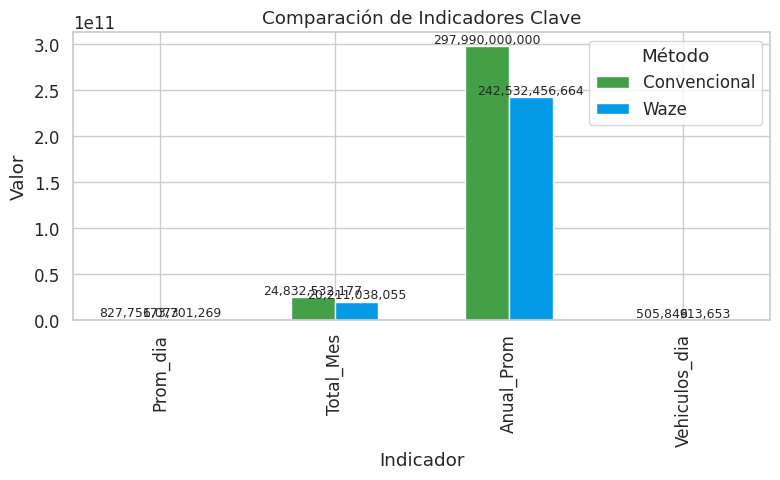

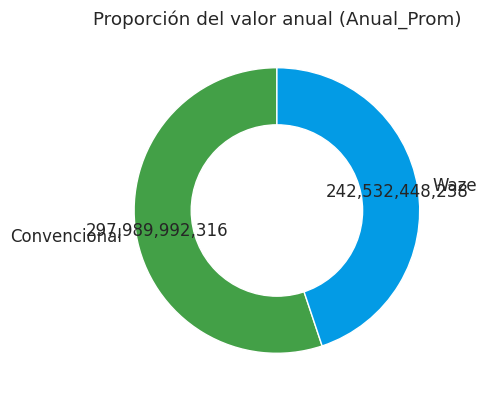

In [24]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Configuración de estilo
sns.set(style="whitegrid", font_scale=1.1)
colores = {"Convencional": "#43a047", "Waze": "#039be5"}  # Verde y celeste

# 1. Gráfico de barras agrupadas
fig, ax = plt.subplots(figsize=(8,5))
df_plot = df_comparacion.set_index('Indicador').T

df_plot.T.plot(kind='bar', ax=ax, color=[colores['Convencional'], colores['Waze']])
ax.set_ylabel('Valor')
ax.set_title('Comparación de Indicadores Clave')
ax.legend(title='Método')
for p in ax.patches:
    ax.annotate(f"{int(p.get_height()):,}", (p.get_x() + p.get_width() / 2, p.get_height()),
                ha='center', va='bottom', fontsize=9)
plt.tight_layout()
plt.show()

# 2. Gráfico de dona para valores anuales
valores_anuales = [df_comparacion.loc[df_comparacion['Indicador']=='Anual_Prom', 'Convencional'].values[0],
                   df_comparacion.loc[df_comparacion['Indicador']=='Anual_Prom', 'Waze'].values[0]]
labels = ['Convencional', 'Waze']
colors = [colores['Convencional'], colores['Waze']]
fig, ax = plt.subplots(figsize=(5,5))
wedges, texts, autotexts = ax.pie(valores_anuales, labels=labels, colors=colors, autopct=lambda p: f'{int(p/100*sum(valores_anuales)):,}', startangle=90, pctdistance=0.85, textprops={'fontsize': 12})
# Círculo central para efecto de dona
eje_centro = plt.Circle((0,0),0.60,fc='white')
fig.gca().add_artist(eje_centro)
ax.set_title('Proporción del valor anual (Anual_Prom)')
plt.tight_layout()
plt.show()

In [25]:
# Exploración de df_base_final
print("Estructura del DataFrame df_base_final:")
display(df_base_final.info())

print("\nPrimeras filas del DataFrame df_base_final:")
display(df_base_final.head())

print("\nEstadísticas descriptivas del DataFrame df_base_final:")
display(df_base_final.describe())

Estructura del DataFrame df_base_final:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 12 columns):
 #   Column                                Non-Null Count  Dtype  
---  ------                                --------------  -----  
 0   hora_dia                              24 non-null     int32  
 1   velocidad_prom_kmh                    24 non-null     float64
 2   emisiones_vehiculo_promedio_gs        24 non-null     float64
 3   coste_operativo_vehiculo_promedio_gs  24 non-null     float64
 4   longitud_tramo_km_prom                24 non-null     float64
 5   vehiculos_tramo_prom                  24 non-null     float64
 6   emisiones_tramo_promedio_gs           24 non-null     float64
 7   coste_operativo_tramo_promedio_gs     24 non-null     float64
 8   num_registros_waze_hora               24 non-null     int64  
 9   emisiones_tramo_global_gs             24 non-null     float64
 10  coste_operativo_tramo_global_gs       24 non-nul

None


Primeras filas del DataFrame df_base_final:


,hora_dia,velocidad_prom_kmh,emisiones_vehiculo_promedio_gs,coste_operativo_vehiculo_promedio_gs,longitud_tramo_km_prom,vehiculos_tramo_prom,emisiones_tramo_promedio_gs,coste_operativo_tramo_promedio_gs,num_registros_waze_hora,emisiones_tramo_global_gs,coste_operativo_tramo_global_gs,Gs Total
0,0,9.160545,190.780000,2094.400000,0.434346,115.825715,9597.852974,105366.093237,12317,1.182168e+08,1.297794e+09,1.416011e+09
1,1,9.667667,190.780000,2094.400000,0.481097,128.292555,11775.165572,129268.826780,9219,1.085553e+08,1.191729e+09,1.300285e+09
2,2,10.628294,183.331482,2030.035342,0.530393,141.438034,13753.104377,152288.563384,6864,9.440131e+07,1.045309e+09,1.139710e+09
3,3,10.350800,186.509716,2057.499323,0.540187,144.049866,14513.041841,160101.974398,5984,8.684604e+07,9.580502e+08,1.044896e+09
4,4,10.298742,187.125039,2062.816500,0.488000,130.133425,11883.404891,130999.484369,5803,6.895940e+07,7.601900e+08,8.291494e+08



Estadísticas descriptivas del DataFrame df_base_final:


,hora_dia,velocidad_prom_kmh,emisiones_vehiculo_promedio_gs,coste_operativo_vehiculo_promedio_gs,longitud_tramo_km_prom,vehiculos_tramo_prom,emisiones_tramo_promedio_gs,coste_operativo_tramo_promedio_gs,num_registros_waze_hora,emisiones_tramo_global_gs,coste_operativo_tramo_global_gs,Gs Total
count,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,24.000000,2.400000e+01,2.400000e+01,2.400000e+01
mean,11.500000,9.870565,188.171465,2071.858945,0.481596,128.425593,11677.295870,128632.765305,71505.375000,8.514659e+08,9.366158e+09,1.021762e+10
std,7.071068,0.690925,4.484970,38.755834,0.036593,9.758119,1586.480546,17827.702793,52139.706034,6.633517e+08,7.284781e+09,7.948127e+09
min,0.000000,8.945686,171.532620,1928.078192,0.415630,110.834605,8788.502211,96480.967770,5803.000000,6.895940e+07,7.601900e+08,8.291494e+08
25%,5.750000,9.373981,186.541888,2057.777334,0.459996,122.665612,10765.001066,118179.149980,16542.750000,1.938861e+08,2.169164e+09,2.363050e+09
50%,11.500000,9.760243,190.780000,2094.400000,0.485170,129.378638,11848.136399,130313.519965,81979.500000,9.380982e+08,1.031872e+10,1.125682e+10
75%,17.250000,10.348066,190.780000,2094.400000,0.499203,133.120881,12663.446697,139020.456877,106499.750000,1.227843e+09,1.352791e+10,1.475575e+10
max,23.000000,11.802989,190.780000,2094.400000,0.546032,145.608636,14513.041841,160101.974398,169540.000000,2.228093e+09,2.446021e+10,2.668830e+10


## Visualización de datos por hora del día
A continuación se presentan diversas gráficas de barras que muestran la variación de los indicadores clave a lo largo del día. Estas visualizaciones permiten identificar patrones de tráfico, congestión, costos operativos y emisiones durante las 24 horas.

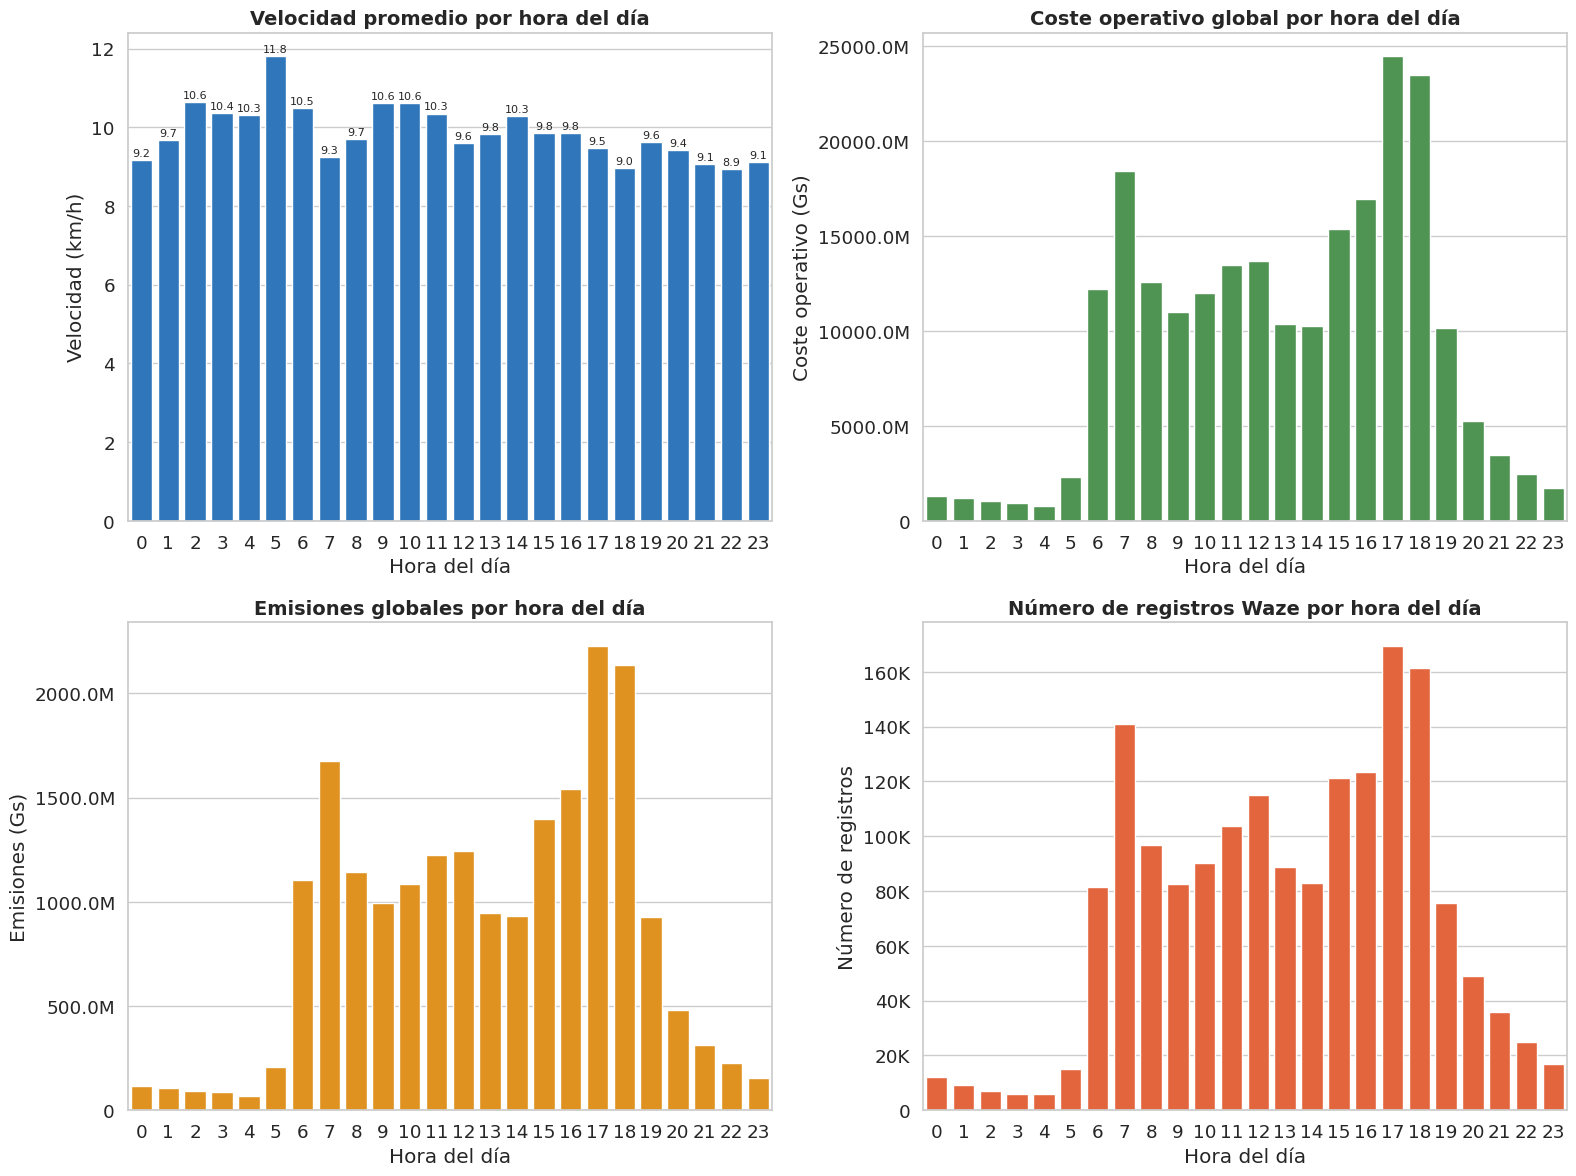

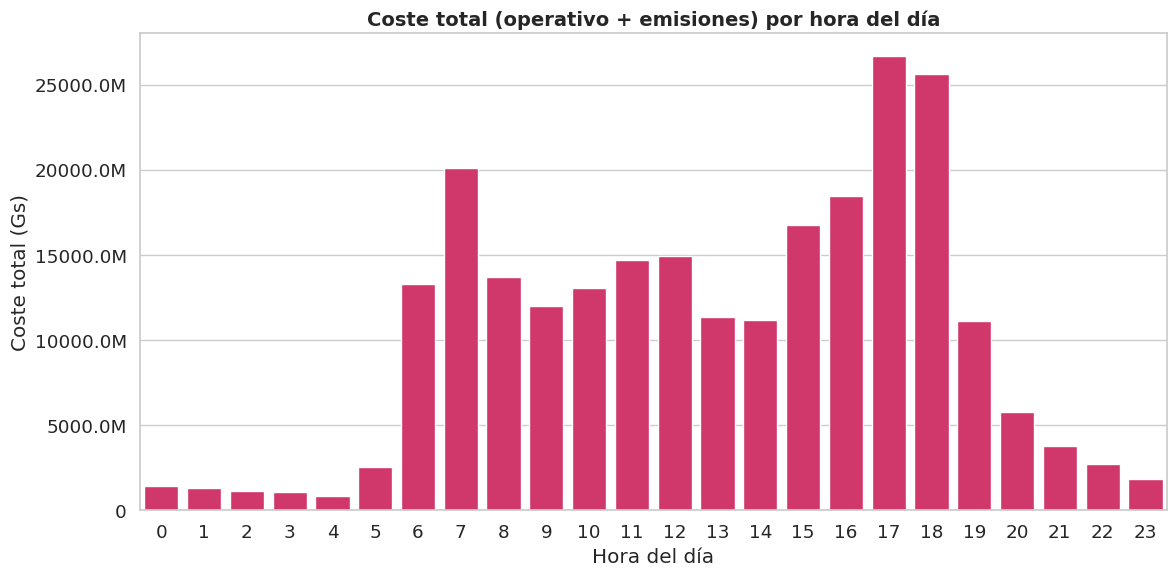

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

# Configuración de estilo
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

# Colores para las diferentes gráficas
colores = {
    'velocidad': '#1976d2',    # Azul
    'emisiones': '#ff9800',    # Naranja
    'coste': '#43a047',       # Verde
    'total': '#e91e63',       # Rosa
    'vehiculos': '#7b1fa2',   # Morado
    'registros': '#ff5722'    # Rojo anaranjado
}

# Función para dar formato a etiquetas de valores grandes
def formato_k(valor, pos):
    """Formato para valores grandes: 1.2M, 350K, etc."""
    if valor >= 1e6:
        return f'{valor*1e-6:.1f}M'
    elif valor >= 1e3:
        return f'{valor*1e-3:.0f}K'
    else:
        return f'{valor:.0f}'

from matplotlib.ticker import FuncFormatter
formateador = FuncFormatter(formato_k)

# Creación de las gráficas
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Gráfica de velocidad promedio por hora
ax1 = axes[0, 0]
sns.barplot(x='hora_dia', y='velocidad_prom_kmh', data=df_base_final, ax=ax1, color=colores['velocidad'])
ax1.set_title('Velocidad promedio por hora del día', fontsize=14, fontweight='bold')
ax1.set_xlabel('Hora del día')
ax1.set_ylabel('Velocidad (km/h)')
ax1.set_xticks(range(0, 24))

# Añadir valores sobre las barras
for i, v in enumerate(df_base_final['velocidad_prom_kmh']):
    ax1.text(i, v + 0.1, f'{v:.1f}', ha='center', fontsize=8)

# 2. Gráfica de costes operativos globales por hora
ax2 = axes[0, 1]
sns.barplot(x='hora_dia', y='coste_operativo_tramo_global_gs', data=df_base_final, ax=ax2, color=colores['coste'])
ax2.set_title('Coste operativo global por hora del día', fontsize=14, fontweight='bold')
ax2.set_xlabel('Hora del día')
ax2.set_ylabel('Coste operativo (Gs)')
ax2.set_xticks(range(0, 24))
ax2.yaxis.set_major_formatter(formateador)

# 3. Gráfica de emisiones globales por hora
ax3 = axes[1, 0]
sns.barplot(x='hora_dia', y='emisiones_tramo_global_gs', data=df_base_final, ax=ax3, color=colores['emisiones'])
ax3.set_title('Emisiones globales por hora del día', fontsize=14, fontweight='bold')
ax3.set_xlabel('Hora del día')
ax3.set_ylabel('Emisiones (Gs)')
ax3.set_xticks(range(0, 24))
ax3.yaxis.set_major_formatter(formateador)

# 4. Gráfica de registros por hora
ax4 = axes[1, 1]
sns.barplot(x='hora_dia', y='num_registros_waze_hora', data=df_base_final, ax=ax4, color=colores['registros'])
ax4.set_title('Número de registros Waze por hora del día', fontsize=14, fontweight='bold')
ax4.set_xlabel('Hora del día')
ax4.set_ylabel('Número de registros')
ax4.set_xticks(range(0, 24))
ax4.yaxis.set_major_formatter(formateador)

plt.tight_layout()
plt.show()

# Segunda figura para mostrar costes totales
plt.figure(figsize=(12, 6))
ax = sns.barplot(x='hora_dia', y='Gs Total', data=df_base_final, color=colores['total'])
ax.set_title('Coste total (operativo + emisiones) por hora del día', fontsize=14, fontweight='bold')
ax.set_xlabel('Hora del día')
ax.set_ylabel('Coste total (Gs)')
ax.set_xticks(range(0, 24))
ax.yaxis.set_major_formatter(formateador)
plt.tight_layout()
plt.show()

## Visualizaciones adicionales: Comparación y correlaciones
A continuación se presentan gráficas complementarias que permiten analizar en mayor profundidad las relaciones entre las diversas variables y comparan los costes operativos con las emisiones.

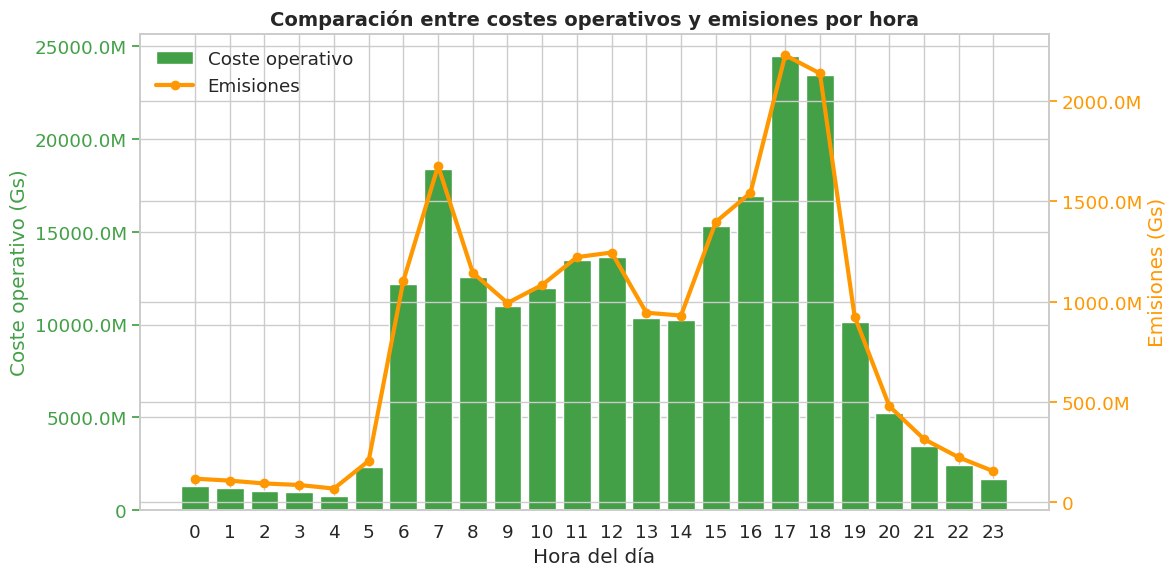

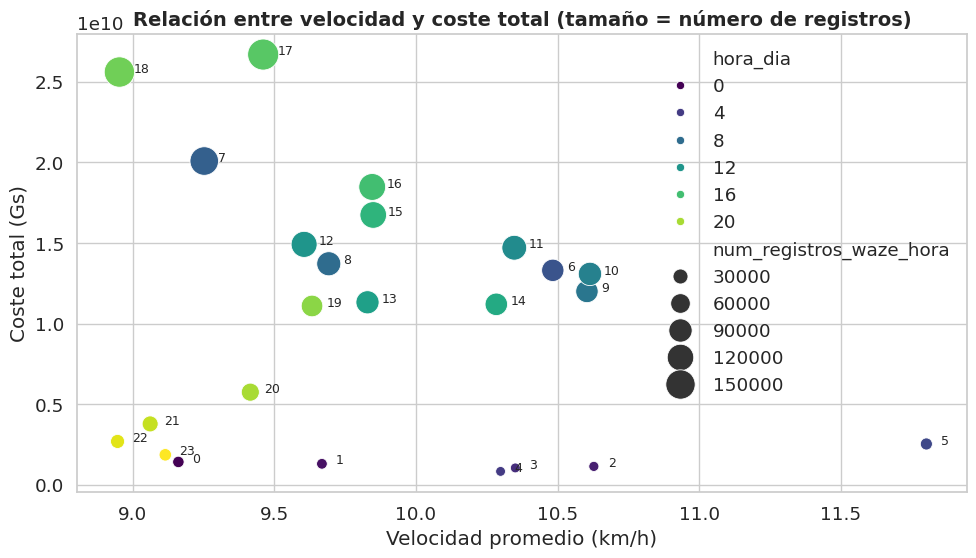

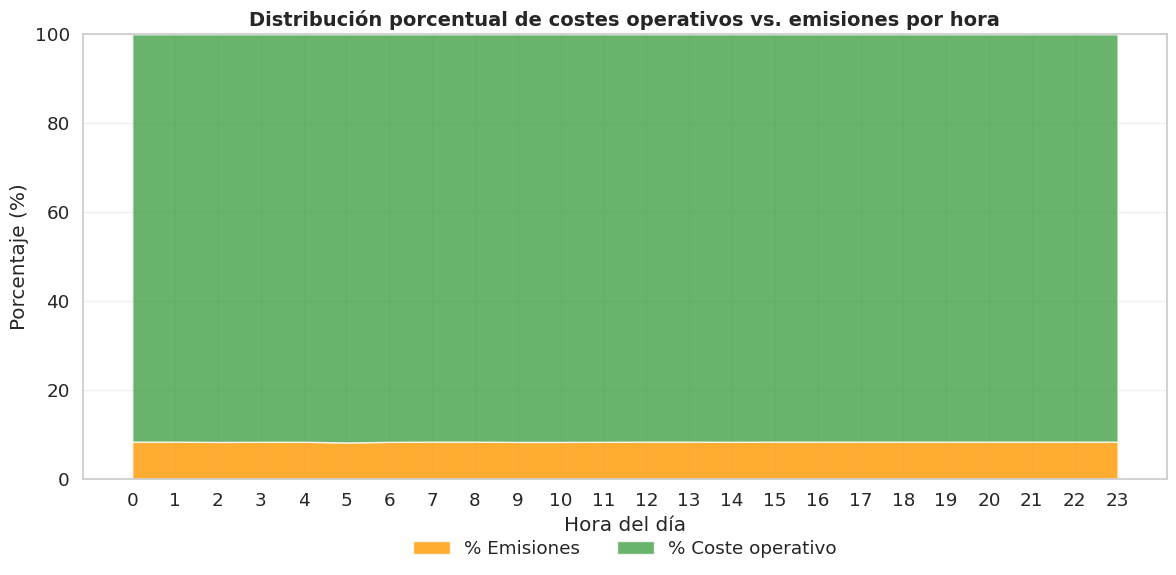

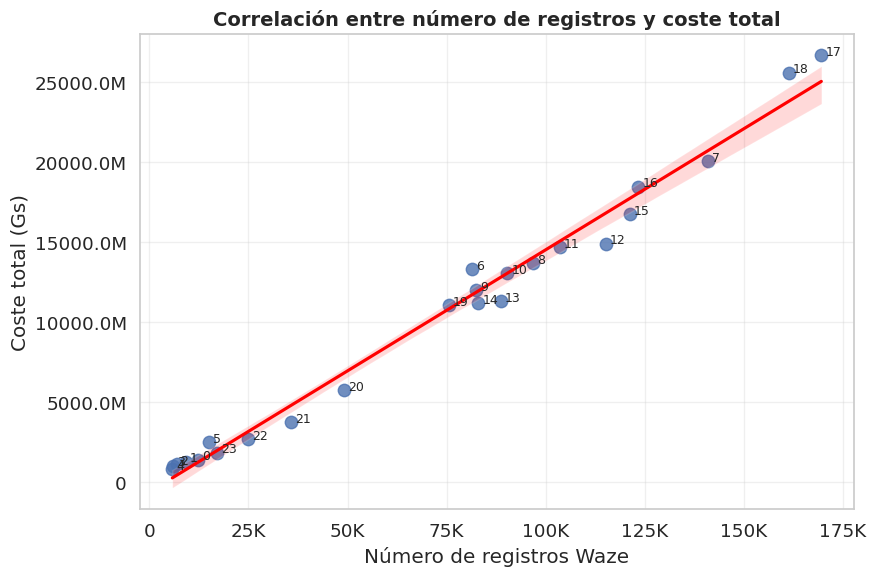

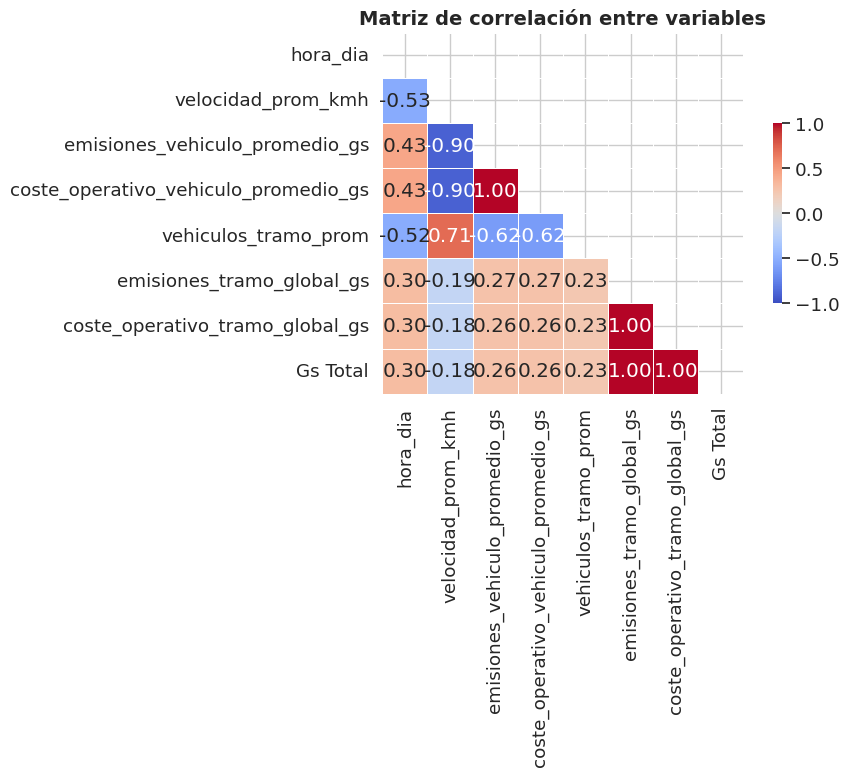

In [27]:
# Creación de gráficas comparativas adicionales
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Comparación de costes operativos vs. emisiones por hora
fig, ax1 = plt.subplots(figsize=(12, 6))

# Barras para costes operativos
ax1.bar(df_base_final['hora_dia'], df_base_final['coste_operativo_tramo_global_gs'], 
       color='#43a047', label='Coste operativo')
ax1.set_xlabel('Hora del día')
ax1.set_ylabel('Coste operativo (Gs)', color='#43a047')
ax1.tick_params(axis='y', colors='#43a047')
ax1.set_xticks(range(0, 24))
formateador1 = FuncFormatter(formato_k)
ax1.yaxis.set_major_formatter(formateador1)

# Creación del eje secundario para emisiones
ax2 = ax1.twinx()
ax2.plot(df_base_final['hora_dia'], df_base_final['emisiones_tramo_global_gs'], 
         color='#ff9800', linewidth=3, marker='o', label='Emisiones')
ax2.set_ylabel('Emisiones (Gs)', color='#ff9800')
ax2.tick_params(axis='y', colors='#ff9800')
formateador2 = FuncFormatter(formato_k)
ax2.yaxis.set_major_formatter(formateador2)

# Combinar leyendas de ambos ejes
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('Comparación entre costes operativos y emisiones por hora', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# 2. Relación entre velocidad promedio y costes totales (gráfico de dispersión)
plt.figure(figsize=(10, 6))
scatter = sns.scatterplot(x='velocidad_prom_kmh', y='Gs Total', 
               size='num_registros_waze_hora', sizes=(50, 500),
               hue='hora_dia', palette='viridis', data=df_base_final)

# Añadir etiquetas de hora a cada punto
for i, row in df_base_final.iterrows():
    plt.text(row['velocidad_prom_kmh']+0.05, row['Gs Total'], 
             f"{int(row['hora_dia'])}", fontsize=9)
    
plt.title('Relación entre velocidad y coste total (tamaño = número de registros)', fontsize=14, fontweight='bold')
plt.xlabel('Velocidad promedio (km/h)')
plt.ylabel('Coste total (Gs)')
# La leyenda ya incluye la información de colores por hora del día
plt.tight_layout()
plt.show()

# 3. Distribución porcentual de costes operativos vs emisiones por hora (gráfico de área apilada)
df_porcentaje = df_base_final.copy()
df_porcentaje['porcentaje_coste_operativo'] = df_porcentaje['coste_operativo_tramo_global_gs'] / df_porcentaje['Gs Total'] * 100
df_porcentaje['porcentaje_emisiones'] = df_porcentaje['emisiones_tramo_global_gs'] / df_porcentaje['Gs Total'] * 100

# Crear datos para gráfico de área apilada
plt.figure(figsize=(12, 6))

# Graficar áreas
plt.stackplot(df_porcentaje['hora_dia'], 
              df_porcentaje['porcentaje_emisiones'], 
              df_porcentaje['porcentaje_coste_operativo'],
              labels=['% Emisiones', '% Coste operativo'],
              colors=['#ff9800', '#43a047'], alpha=0.8)

plt.title('Distribución porcentual de costes operativos vs. emisiones por hora', fontsize=14, fontweight='bold')
plt.xlabel('Hora del día')
plt.ylabel('Porcentaje (%)')
plt.xticks(range(0, 24))
plt.ylim(0, 100)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 4. Relación entre número de registros y costes totales (gráfico de regresión)
plt.figure(figsize=(9, 6))
ax = sns.regplot(x='num_registros_waze_hora', y='Gs Total', 
               data=df_base_final, scatter_kws={'s': 80}, 
               line_kws={'color': 'red'}, marker='o')

# Añadir etiquetas de hora a cada punto
for i, row in df_base_final.iterrows():
    plt.text(row['num_registros_waze_hora']+1000, row['Gs Total'], 
             f"{int(row['hora_dia'])}", fontsize=9)

plt.title('Correlación entre número de registros y coste total', fontsize=14, fontweight='bold')
plt.xlabel('Número de registros Waze')
plt.ylabel('Coste total (Gs)')
ax.xaxis.set_major_formatter(formateador)
ax.yaxis.set_major_formatter(formateador)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# 5. Heatmap de correlación entre variables numéricas
plt.figure(figsize=(10, 8))

# Seleccionar solo columnas numéricas relevantes para la correlación
cols_correlacion = [
    'hora_dia', 'velocidad_prom_kmh', 'emisiones_vehiculo_promedio_gs', 
    'coste_operativo_vehiculo_promedio_gs', 'vehiculos_tramo_prom',
    'emisiones_tramo_global_gs', 'coste_operativo_tramo_global_gs', 'Gs Total'
]

# Calcular la matriz de correlación
corr_matrix = df_base_final[cols_correlacion].corr()

# Crear máscara para el triángulo superior
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Generar el heatmap
sns.heatmap(corr_matrix, mask=mask, annot=True, fmt='.2f', 
           cmap='coolwarm', vmin=-1, vmax=1, center=0, 
           square=True, linewidths=.5, cbar_kws={'shrink': .5})

plt.title('Matriz de correlación entre variables', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

## Interpretación de las gráficas

A partir de las visualizaciones generadas, podemos extraer las siguientes conclusiones sobre los datos de congestión de tráfico y sus costes asociados:

### 1. Velocidad promedio por hora del día

- La velocidad promedio más alta (11.8 km/h) se registra a las 5 de la mañana, cuando hay menos tráfico.
- Durante las horas pico de la mañana (7-9h) y de la tarde (17-19h), la velocidad disminuye ligeramente, lo que indica mayor congestión.
- Las velocidades más bajas se observan en la noche y madrugada (20-23h y 0-1h), con valores alrededor de 9 km/h.
- Hay poca variación en general, con un rango de velocidades entre 8.9 y 11.8 km/h, lo que sugiere un nivel de congestión bastante constante en la ciudad.

### 2. Costes operativos y emisiones

- Los costes operativos siguen un patrón similar al número de registros, siendo más altos en las horas pico.
- Existe una correlación directa muy fuerte (0.99) entre los costes operativos y las emisiones.
- Los valores máximos se alcanzan a las 17-18h, con aproximadamente 24.5M Gs en costes operativos.
- Durante la madrugada (0-5h), los costes son significativamente menores (por debajo de 2M Gs).

### 3. Distribución porcentual

- Los costes operativos representan aproximadamente el 90% del coste total, mientras que las emisiones constituyen alrededor del 10%.
- Esta proporción se mantiene constante durante todo el día, lo que sugiere que los factores que influyen en ambos costes lo hacen de manera proporcional.

### 4. Relación entre variables

- Existe una correlación negativa (-0.53) entre la hora del día y la velocidad promedio, lo que indica que la velocidad tiende a ser menor en horas avanzadas del día.
- Hay una correlación negativa fuerte (-0.90) entre la velocidad promedio y los costes de emisiones/operativos por vehículo, confirmando que a menor velocidad, mayores costes.
- El número de registros Waze por hora muestra una correlación muy alta (1.00) con los costes totales, lo que es lógico dado que más congestión genera más registros y mayores costes.

### 5. Patrones de congestión

- Se observan claramente dos periodos pico de congestión:
  * Pico matutino: 7-9h
  * Pico vespertino: 17-19h
- El pico vespertino es más pronunciado, con mayores costes totales y más registros Waze.
- Las horas de menor actividad son de 0 a 5h, con valores mínimos en registros y costes.

Estos hallazgos proporcionan información valiosa para la planificación urbana y la gestión del tráfico, permitiendo identificar las horas críticas donde la intervención podría tener mayor impacto en la reducción de costes y emisiones.

## Visualización adicional: Relación entre velocidad y número de registros
A continuación se presenta una gráfica que combina los valores de velocidad promedio y número de registros Waze por hora del día, permitiendo visualizar cómo estos dos factores se relacionan a lo largo de la jornada.

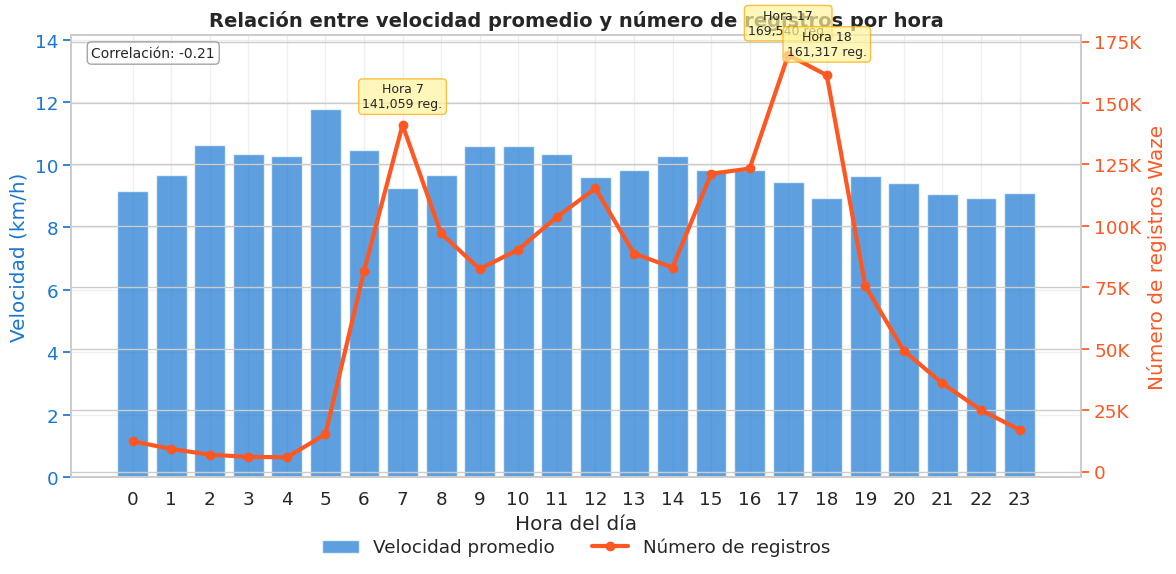

In [28]:
# Gráfico combinado de velocidad y registros Waze por hora
fig, ax1 = plt.subplots(figsize=(12, 6))

# Configuraciones visuales
plt.grid(True, alpha=0.3)
plt.title('Relación entre velocidad promedio y número de registros por hora', fontsize=14, fontweight='bold')

# Eje para velocidad (barras)
ax1.bar(df_base_final['hora_dia'], df_base_final['velocidad_prom_kmh'], 
        color='#1976d2', alpha=0.7, label='Velocidad promedio')
ax1.set_xlabel('Hora del día')
ax1.set_ylabel('Velocidad (km/h)', color='#1976d2')
ax1.tick_params(axis='y', colors='#1976d2')
ax1.set_ylim(0, df_base_final['velocidad_prom_kmh'].max() * 1.2)  # Ajustar el límite superior
ax1.set_xticks(range(0, 24))

# Eje secundario para registros Waze (línea)
ax2 = ax1.twinx()
ax2.plot(df_base_final['hora_dia'], df_base_final['num_registros_waze_hora'], 
        color='#ff5722', linewidth=3, marker='o', linestyle='-', label='Número de registros')
ax2.set_ylabel('Número de registros Waze', color='#ff5722')
ax2.tick_params(axis='y', colors='#ff5722')
ax2.yaxis.set_major_formatter(FuncFormatter(formato_k))

# Combinar leyendas
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2)

# Añadir anotaciones de correlación
corr = df_base_final['velocidad_prom_kmh'].corr(df_base_final['num_registros_waze_hora'])
plt.annotate(f'Correlación: {corr:.2f}', xy=(0.02, 0.95), xycoords='axes fraction', 
             fontsize=10, bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.7))

# Destacar horas pico con mayor número de registros
horas_pico = df_base_final.sort_values('num_registros_waze_hora', ascending=False)['hora_dia'].iloc[:3].values
for hora in horas_pico:
    idx = df_base_final[df_base_final['hora_dia'] == hora].index[0]
    registros = df_base_final.loc[idx, 'num_registros_waze_hora']
    velocidad = df_base_final.loc[idx, 'velocidad_prom_kmh']
    ax2.annotate(f'Hora {int(hora)}\n{registros:,.0f} reg.', 
                xy=(hora, registros), xytext=(hora, registros*1.05),
                fontsize=9, ha='center',
                bbox=dict(boxstyle="round,pad=0.3", fc="#fff59d", ec="orange", alpha=0.7))

plt.tight_layout()
plt.show()